<a href="https://www.kaggle.com/code/fiftythirtyfour/on-time-performance-usa-2023?scriptVersionId=239007605" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📥 Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('/kaggle/input/2023-us-civil-flights-delay-meteo-and-aircraft/US_flights_2023.csv')

df.columns = df.columns.str.lower()

df['flightdate'] = pd.to_datetime(df['flightdate'])

num = df.select_dtypes(include='number').columns.to_list()
cat = df.select_dtypes(include='object').columns.to_list()

df['dep_otp_15'] = np.where(df['dep_delay'] > 15, 0, 1)
target = 'dep_otp_15'

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2)

# 🤓 Data Science

In [3]:
df[num].corrwith(df[target]).sort_values(ascending=False)

aicraft_age          -0.007045
day_of_week          -0.027177
delay_security       -0.035377
flight_duration      -0.041338
delay_weather        -0.101854
delay_nas            -0.184385
delay_carrier        -0.272477
delay_lastaircraft   -0.370870
arr_delay            -0.522125
dep_delay            -0.534136
dep_delay_tag        -0.635566
dtype: float64

In [4]:
df.groupby(['airline'])[target].mean()

airline
Alaska Airlines Inc.            0.830364
Allegiant Air                   0.770461
American Airlines Inc.          0.785835
American Eagle Airlines Inc.    0.849832
Delta Air Lines Inc             0.834972
Endeavor Air                    0.870547
Frontier Airlines Inc.          0.695404
Hawaiian Airlines Inc.          0.806781
JetBlue Airways                 0.693881
PSA Airlines                    0.858268
Republic Airways                0.895633
Skywest Airlines Inc.           0.861087
Southwest Airlines Co.          0.764415
Spirit Air Lines                0.713411
United Air Lines Inc.           0.806853
Name: dep_otp_15, dtype: float64

# 🤖 Machine

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num = ['delay_lastaircraft']
cat = ['airline']
processor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), num)
    , (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat)
)

processor.fit(train)
train_pre = processor.transform(train)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000)
log.fit(train_pre, train[target])
print(cross_val_score(log, train_pre, train[target], scoring='accuracy').mean())

model = log
pipe = make_pipeline(processor, model)

0.8906030948518475


# 🦾 Residuals

              precision    recall  f1-score   support

           0       0.96      0.47      0.63    266487
           1       0.88      0.99      0.94   1082194

    accuracy                           0.89   1348681
   macro avg       0.92      0.73      0.78   1348681
weighted avg       0.90      0.89      0.88   1348681



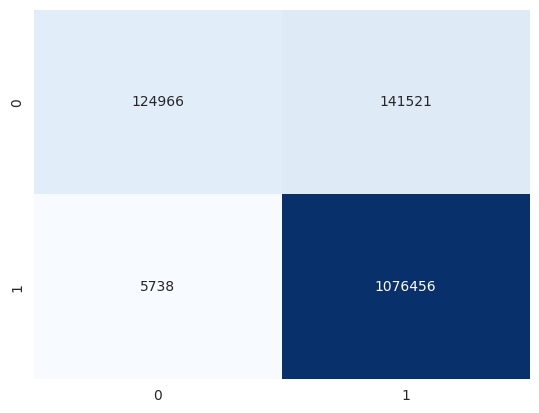

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

preds = pipe.predict(test)
print(classification_report(test[target], preds))
sns.heatmap(confusion_matrix(test[target], preds), annot=True, fmt='.0f', cbar=False, cmap='Blues');

# 🚀 Deploy

In [8]:
df.to_csv('otp_usa_2023.csv', index=False)